In [1]:
import pandas as pd
import numpy as np

In [2]:
################################################################################################################
#                   This is to create a csv file(train.csv) by combining all the four files                    #
################################################################################################################
# # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
# train = open('train.csv', mode='a')

# row = list()
# files=['netflix/combined_data_1.txt','netflix/combined_data_2.txt', 
#        'netflix/combined_data_3.txt', 'netflix/combined_data_4.txt']
# for file in files:
#     with open(file) as f:
#         for line in f:
#             del row[:]
#             line = line.strip()
#             if line.endswith(':'):
#                 movie_id = line.replace(':', '')
#             else:
#                 row = [x for x in line.split(',')]
#                 row.insert(0, movie_id)
#                 train.write(','.join(row))
#                 train.write('\n')
# train.close()

## We are removing duplicates and store them in a new csv file

In [3]:
# prev = train_df.shape[0];

# print('With duplicates    :', prev)
# train_df.drop_duplicates(inplace=True)
# present = train_df.shape[0]
# print("Without duplicates :", present)


# there were 716 duplicate rows....
# print("\n There were",(present-prev),"duplicates")

In [ ]:
# train_df.to_csv('new_train.csv', index=False)

In [5]:
train_df = pd.read_csv('new_train.csv', sep=',')
train_df.head()

,movie,user,rating,date
0,1,1488844,3.0,2005-09-06
1,1,822109,5.0,2005-05-13
2,1,885013,4.0,2005-10-19
3,1,30878,4.0,2005-12-26
4,1,823519,3.0,2004-05-03


In [6]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

In [7]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


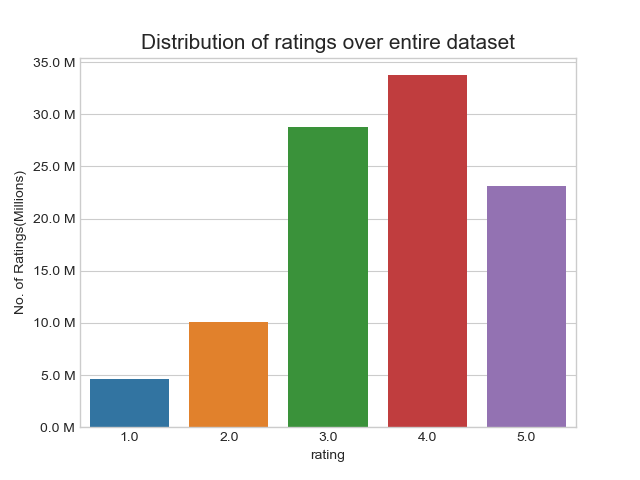

In [8]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over entire dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [9]:
movies = train_df.movie.value_counts().sort_index()
users = train_df.user.value_counts().sort_index()
ratings = train_df.rating

print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))


Total no of ratings : 100479540
Total No of Users   : 480189
Total No of movies  : 17770


## Creating sparse matrix for user-movie-rating from dataframe 

In [ ]:
from scipy.sparse import csr_matrix
# csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
# It should be in such a way that, MATRIX[row, col] = data
sparse_matrix = csr_matrix((train_df.rating.tolist(), (train_df.user.tolist(),
                                               train_df.movie.tolist())), 
                           shape=(max(train_df.user)+1,max(train_df.movie)+1))
print('(user, movie) : ',sparse_matrix.shape)

In [19]:
# u : row indices(userIds) that has an entry(rating to some movie)
# m : column indices(movieIds) that has an entry(rated by some user)
#  One entry from both (x and y) is a non-zero entry....
u,m = sparse_matrix.nonzero()


# ".A1" is for converting Column matrix to 1-D numpy array 
sum_of_ratings_per_user = sparse_matrix.sum(axis=1).A1
# no of ratings that each user has given.
no_ratings_per_user = (sparse_matrix!=0).sum(axis=1).A1


# sum of the ratings that a movie got by any user(who rated that movie..)
sum_of_ratings_per_movie = sparse_matrix.sum(axis=0).A1
# no of ratings that a movie got.
no_ratings_per_movie = (sparse_matrix!=0).sum(axis=0).A1
# ratings_per_movie = ratings_per_movie[ratings_per_movie!=0]

# calculate AVERAGE Rating w.r.t user and movie.
avg_rating_per_movie = np.divide(sum_of_ratings_per_movie, no_ratings_per_movie, where=no_ratings_per_movie!=0)
avg_rating_per_user = avg_rating_per_user[avg_rating_per_user<=5]
avg_rating_per_user  = np.divide(sum_of_ratings_per_user, no_ratings_per_user, where=no_ratings_per_user!=0)

# We don't get empty columns(movies), but We have empty rows(users),
# Because all movies are from 1 to XXX,XXX. But users are selected at random...
avg_rating_per_user = avg_rating_per_user[avg_rating_per_user!=0]

<IPython.core.display.Javascript object>


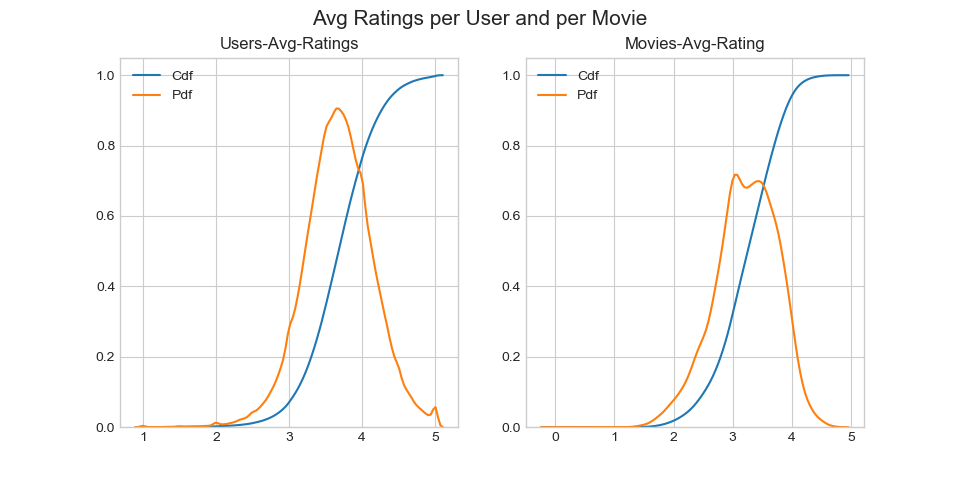

In [136]:
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

# print('plotting cdf of user')
ax1.set_title('Users-Avg-Ratings')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of user')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False,label='Pdf')

# print('plotting cdf of movie')
ax2.set_title('Movies-Avg-Rating')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of movie')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, label='Pdf')

plt.show()